# Introduction to *Blue Book for Bulldozers*

The goal of this project is to predict the sale price of a particular piece of heavy equipment at auction based on it's usage, equipment type, and configuration. The data is sourced from auction result postings and includes information on usage and equipment configurations. Fast Iron is creating a "blue book for bulldozers," for customers to value what their heavy equipment fleet is worth at auction.

<h1>Imports</h1>

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *

from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics

In [3]:
PATH = "data/"

In [5]:
!ls {PATH}

Train.csv


In [6]:
!head data/Train.csv

In [7]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False,parse_dates=["saledate"])

In [8]:
def display_all(df):
    with pd.option_context("display.max_rows",1000,"display.max_columns",1000):
        display(df)

In [9]:
display_all(df_raw.tail().transpose())

,401120,401121,401122,401123,401124
SalesID,6333336,6333337,6333338,6333341,6333342
SalePrice,10500,11000,11500,9000,7750
MachineID,1840702,1830472,1887659,1903570,1926965
ModelID,21439,21439,21439,21435,21435
datasource,149,149,149,149,149
auctioneerID,1,1,1,2,2
YearMade,2005,2005,2005,2005,2005
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-11-02 00:00:00,2011-10-25 00:00:00,2011-10-25 00:00:00


It's important to note what metric is being used for a project. Generally, selecting the metric(s) is an important part of the project setup. However, in this case Kaggle tells us what metric to use: RMSLE (root mean squared log error) between the actual and predicted auction prices. Therefore we take the log of the prices, so that RMSE will give us what we need.

In [10]:
df_raw.SalePrice = np.log(df_raw.SalePrice)
# display_all(df_raw.SalePrice)

<h2>Initial Processing</h2>

In [11]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df_raw.drop('SalePrice',axis=1),df_raw.SalePrice)

ValueError: could not convert string to float: 'Conventional'

In [12]:
# df_raw.saledate
add_datepart(df_raw,'saledate')

In [13]:
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

In [14]:
df_raw.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc', 'fiModelSeries',
       'fiModelDescriptor', 'ProductSize', 'fiProductClassDesc', 'state',
       'ProductGroup', 'ProductGroupDesc', 'Drive_System', 'Enclosure',
       'Forks', 'Pad_Type', 'Ride_Control', 'Stick', 'Transmission',
       'Turbocharged', 'Blade_Extension', 'Blade_Width', 'Enclosure_Type',
       'Engine_Horsepower', 'Hydraulics', 'Pushblock', 'Ripper', 'Scarifier',
       'Tip_Control', 'Tire_Size', 'Coupler', 'Coupler_System',
       'Grouser_Tracks', 'Hydraulics_Flow', 'Track_Type',
       'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb', 'Pattern_Changer',
       'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type', 'Travel_Controls',
       'Differential_Type', 'Steering_Controls', 'saleYear', 'saleMonth',
       'saleWeek', 'saleDay', 'saleDayofweek', 'saleDayofyear',


In [86]:
df_raw.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,16,3,320,False,False,False,False,False,False,1163635200
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,26,4,86,False,False,False,False,False,False,1080259200
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,26,3,57,False,False,False,False,False,False,1077753600
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,19,3,139,False,False,False,False,False,False,1305763200
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,23,3,204,False,False,False,False,False,False,1248307200


Converting categorical variables into numbers using train_cats method of fast.ai

In [15]:
train_cats(df_raw)

In [16]:
df_raw.UsageBand.cat.categories

Index(['High', 'Low', 'Medium'], dtype='object')

Arranging the category in sensible order

In [17]:
df_raw.UsageBand.cat.set_categories(['High', 'Low', 'Medium'],ordered=True, inplace=True)

In [18]:
df_raw.UsageBand = df_raw.UsageBand.cat.codes

Before surving the data to random forest we need to work on null fields

In [19]:
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

But let's save this file for now, since it's already in format can we be stored and accessed efficiently.

In [20]:
os.makedirs('tmp',exist_ok=True)
df_raw.to_feather('tmp/raw')

In [3]:
df_raw = pd.read_feather('tmp/raw')

We'll replace categories with their numeric codes, handle missing continuous values, and split the dependent variable into a separate variable.

In [4]:
df, y, nas = proc_df(df_raw, 'SalePrice')

We now have something we can pass to a random forest!

In [5]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(df, y)
m.score(df,y)

0.9829993840300145

Wow, an r^2 of 0.98 - that's great, right? Well, perhaps not...

Possibly **the most important idea** in machine learning is that of having separate training & validation data sets. As motivation, suppose you don't divide up your data, but instead use all of it.  And suppose you have lots of parameters. If you were to gather some new data points, they most likely would not be on that curve in the graph on the right, but would be closer to the curve in the middle graph.

This illustrates how using all our data can lead to **overfitting**. A validation set helps diagnose this problem.

In [9]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

# Random Forests

## Base model

Let's try our model again, this time with separate training and validation sets.



In [8]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())  #x-prediction, y-actuals

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), 
           rmse(m.predict(X_valid), y_valid),
           m.score(X_train, y_train), 
           m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): 
        res.append(m.oob_score_)
    print(res)

In [10]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 18s, sys: 492 ms, total: 1min 18s
Wall time: 25.3 s
[0.09042164652321724, 0.2476523404788157, 0.9829124559122432, 0.8904700605952585]


In [108]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 1min 14s, sys: 220 ms, total: 1min 14s
Wall time: 24 s
[0.090671608755524, 0.24917433467206995, 0.9828178514772862, 0.8891196498809967]


An r^2 in the high-80's isn't bad at all (and the RMSLE puts us around rank 100 of 470 on the Kaggle leaderboard), but we can see from the validation set score that we're over-fitting badly. To understand this issue, let's simplify things down to a single small tree.

# 3.2 Speeding things up

In [11]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice', subset=30000, na_dict=nas)
X_train, _ = split_vals(df_trn, 20000)
y_train, _ = split_vals(y_trn, 20000)

In [12]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 2.94 s, sys: 8 ms, total: 2.95 s
Wall time: 963 ms
[0.11353828748475454, 0.38099164430309435, 0.9724335864620792, 0.7407738104075392]


# 3.3 Single Tree

In [95]:
m = RandomForestRegressor(n_estimators=1, max_depth=3,bootstrap=False,n_jobs=-1)
# n_estimators - num of tree, bootrap - randomize
%time m.fit(X_train,y_train)
print_score(m)

CPU times: user 104 ms, sys: 4 ms, total: 108 ms
Wall time: 151 ms
[0.5244545330412972, 0.5811473897143539, 0.4065521304199139, 0.3968566318413335]


In [15]:
# draw_tree(m.estimators_[0],df_trn, precision=3)

Let's see what happens if we create a bigger tree.

In [74]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train,y_train)
print_score(m)

[5.891509130072236e-17, 0.49516154845023974, 1.0, 0.5621334203583377]


The training set result looks great! But the validation set is worse than our original model. This is why we need to use bagging of multiple trees to get more generalizable results.

# 3.4 Bagging

### Intro to bagging


To learn about bagging in random forests, let's start with our basic model again.

In [85]:
m =  RandomForestRegressor(n_jobs=-1)
m.fit(X_train,y_train)
print_score(m)

[0.11339912052918132, 0.3759840920185235, 0.9719727166894251, 0.7475432922174632]


We'll grab the predictions for each individual tree, and loot at one example.

In [86]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]),y_valid[0]

(array([9.15905, 9.21034, 9.15905, 8.92266, 9.25913, 9.15905, 9.15905, 9.68034, 9.61581, 8.92266]),
 9.224712529883139,
 9.104979856318357)

In [78]:
preds.shape

(10, 12000)

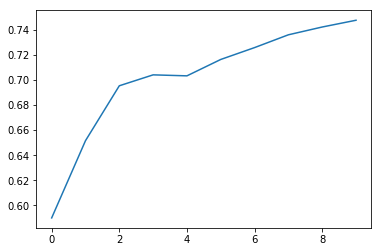

In [87]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

The shape of this curve suggests that adding more trees isn't going to help us much. Let's check. (Compare this to our original model on a sample)



In [80]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.10149029798301602, 0.3718413018994154, 0.977550292543761, 0.753076043074817]


In [83]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09726330960666418, 0.3558956015426551, 0.9793813741695797, 0.7737996798268385]


In [82]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09445353479822491, 0.3538034975382901, 0.9805554426184369, 0.7764512644915582]


## Out-of-bag (OOB) score

Is our validation set worse than our training set because we're over-fitting, or because the validation set is for a different time period, or a bit of both? With the existing information we've shown, we can't tell. However, random forests have a very clever trick called *out-of-bag (OOB) error* which can handle this (and more!)

The idea is to calculate error on the training set, but only include the trees in the calculation of a row's error where that row was *not* included in training that tree. This allows us to see whether the model is over-fitting, without needing a separate validation set.

This also has the benefit of allowing us to see whether our model generalizes, even if we only have a small amount of data so want to avoid separating some out to create a validation set.

This is as simple as adding one more parameter to our model constructor. We print the OOB error last in our `print_score` function below.

In [14]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.09835064589174848, 0.3611227469234437, 0.9793152621650306, 0.7671063408100666, 0.8536378968038005]


This shows that our validation set time diffrence is making an impact, as is model over-fitting.

# 3.5 Reducing over-fitting

## 3.5.1 Subsampling

It turns out that one of the easiest ways to avoid over-fitting is also one of the best ways to speed up analysis: subsampling. Let's return to using our full dataset, so that we can demonstrate the impact of this technique.

In [17]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')
X_train, _ = split_vals(df_trn, n_trn)
y_train, _ = split_vals(y_trn, n_trn)

The basic idea is this: rather than limit the total amount of data that our model can access, let's instead limit it to a different random subset per tree. That way, given enough trees, the model can still see all the data, but for each individual tree it'll be just as fast as if we had cut down our dataset as before.

In [27]:
set_rf_samples(20000)

In [22]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 8.06 s, sys: 448 ms, total: 8.5 s
Wall time: 4.26 s
[0.23962384676913273, 0.27562483332779264, 0.8799962278673015, 0.864329738412567, 0.8675118856362477]


Since each additional tree allows the model to see more data, this approach can make additional trees more useful.

In [23]:
m = RandomForestRegressor(n_estimators=400,n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 4min 41s, sys: 8.56 s, total: 4min 50s
Wall time: 1min 47s
[0.22311153990677066, 0.25824499418089536, 0.8959651384640633, 0.8808999900372525, 0.8847234701017861]


# 3.5.2 Tree building parameters

We revert to using a full bootstrap sample in order to show the impact of other over-fitting avoidance methods.

In [30]:
reset_rf_samples()

Let's get a baseline for this full set to compare to.

In [25]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.07834040827260037, 0.23764731833165142, 0.98717354956694, 0.8991411969238033, 0.9083313971710262]


Another way to reduce over-fitting is to grow our trees less deeply. We do this by specifying (with min_samples_leaf) that we require some minimum number of rows in every leaf node. This has two benefits:

There are less decision rules for each leaf node; simpler models should generalize better
The predictions are made by averaging more rows in the leaf node, resulting in less volatility

In [28]:
m = RandomForestRegressor(n_estimators=400, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)
#with random samples

[0.23276233512434527, 0.2640232661676925, 0.8867703311837867, 0.8755106003390509, 0.8776647164490257]


In [31]:
#without random samples
m = RandomForestRegressor(n_estimators=400, min_samples_leaf=3, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11269637948859162, 0.2311053010689408, 0.9734567098699058, 0.9046177003960575, 0.9133056202782942]


We can also increase the amount of variation amongst the trees by not only use a sample of rows for each tree, but to also using a sample of columns for each split. We do this by specifying max_features, which is the proportion of features to randomly select from at each split.

- None
- 0.5
- 'sqrt'

- 1, 3, 5, 10, 25, 100

In [33]:
#Just trying with more numbers of trees
m = RandomForestRegressor(n_estimators=500, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11669204419586994, 0.2252058162558762, 0.9715411516295708, 0.9094252426643913, 0.9169854241392731]


In [39]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.11911170530100113, 0.22704248667946958, 0.9703487019092643, 0.9079418499136218, 0.9118609547656654]


In [41]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=1, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.28870951402190514, 0.39256412726490725, 0.825796443400868, 0.7247868405982721, 0.7717761564260593]


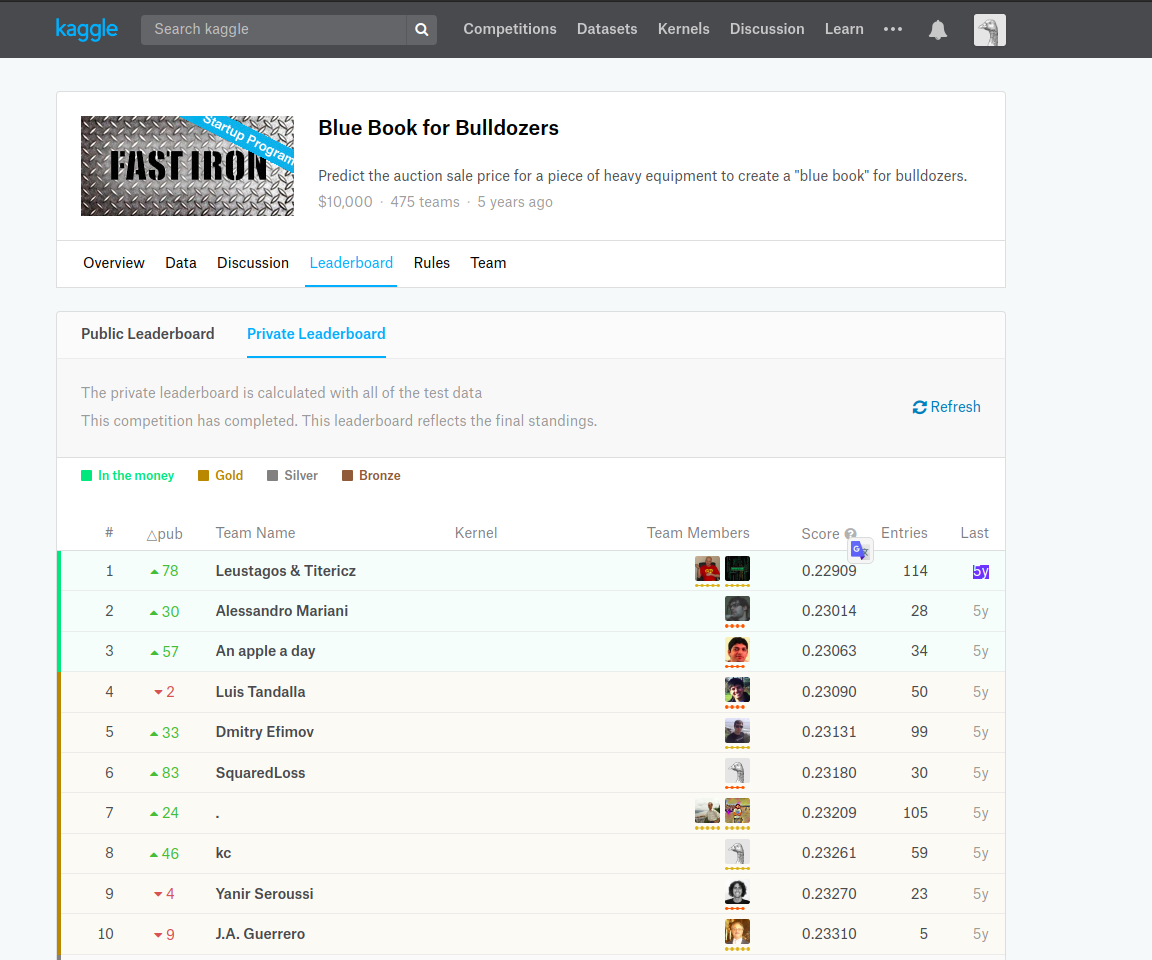
We beat top ten on kaggle